In [2]:
import CS_functions as cs
import numpy as np
from matplotlib import pyplot as plt
from scipy import fft as spfft
from scipy.constants import speed_of_light as C
plt.rcParams.update({'font.size':24, 'xtick.minor.visible': True, 'ytick.minor.visible': False,
                     'xtick.direction': 'in', 'ytick.direction': 'in', "xtick.top": True, "ytick.right": True,
                     'lines.linewidth': 2.4, 'lines.markersize': 10.0, 'lines.markeredgewidth': 2.4})

In [3]:
peak_freqs = (270e9, 450e9)
FWHM = 67e9; total_points = 53; pixel_pitch= 1e-3; theta= 200/60
target = cs.generate_interferogram(total_points, central_freq= peak_freqs[0], pixel_pitch=pixel_pitch, FWHM_freq= FWHM, theta= theta)
target += cs.generate_interferogram(total_points, central_freq= peak_freqs[1], pixel_pitch=pixel_pitch, FWHM_freq= FWHM, theta= theta)

uncertainties = np.ones_like(target)

test_config = [26,29,23,32,37,13,51,43]
regularization_coeffient = 1e-3


reduced_points = len(test_config)

detectors, score = cs.douglas_peucker(reduced_points, target, uncertainties, regularization_coeffient)
print(*detectors, sep= ",")

26,29,23,32,37,13,51,43


In [4]:
samples = np.full_like(target, np.nan)
samples[test_config] = target[test_config]
test_result = cs.compressed_sensing(samples, regularization_coeffient)

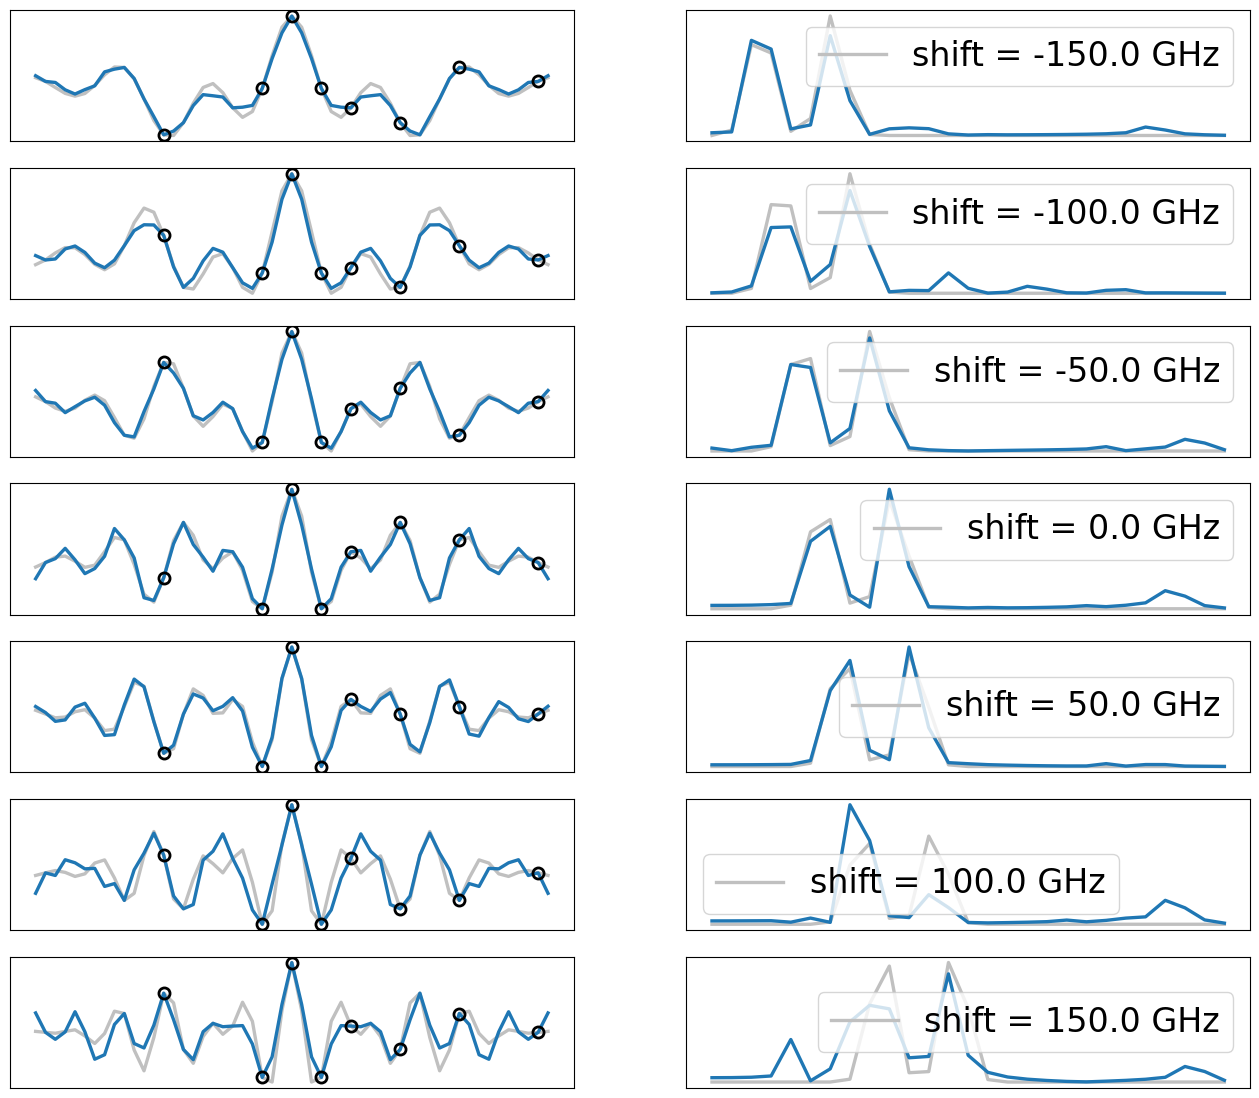

In [10]:
N = 7; shift_range= 150e9
shifts = np.linspace(-shift_range, shift_range, N)

fig, axs = plt.subplots(N, 2, figsize= (16, 2*N))

for ax, shift in zip(axs, shifts):

    target = cs.generate_interferogram(total_points, central_freq= peak_freqs[0] +shift, pixel_pitch=pixel_pitch, FWHM_freq= FWHM, theta= theta)
    target += cs.generate_interferogram(total_points, central_freq= peak_freqs[1] +shift, pixel_pitch=pixel_pitch, FWHM_freq= FWHM, theta= theta)
    uncertainties = np.ones_like(target)

    samples = np.full_like(target, np.nan)
    samples[test_config] = target[test_config]
    test_result = cs.compressed_sensing(samples, regularization_coeffient)

    ax[0].plot(target, color= "silver", label= "actual signal")
    ax[0].plot(test_result, color= "tab:blue", label= "")
    ax[0].plot(test_config, target[test_config], linestyle= "none", marker= "o", color= "black", markerfacecolor= "none", markeredgewidth= 2, markersize= 8, label= "samples")
    ax[0].set(xticks= [], yticks= [])

    target_FFT = np.fft.rfft(target)
    target_FFT = np.abs(target_FFT)
    reconstruction_FFT = np.fft.rfft(test_result)
    reconstruction_FFT = np.abs(reconstruction_FFT)

    ax[1].plot(target_FFT, color= "silver", label= f"shift = {shift*1e-9} GHz")
    ax[1].plot(reconstruction_FFT, color= "tab:blue")
    ax[1].set(xticks= [], yticks= [])
    ax[1].legend()

plt.show()

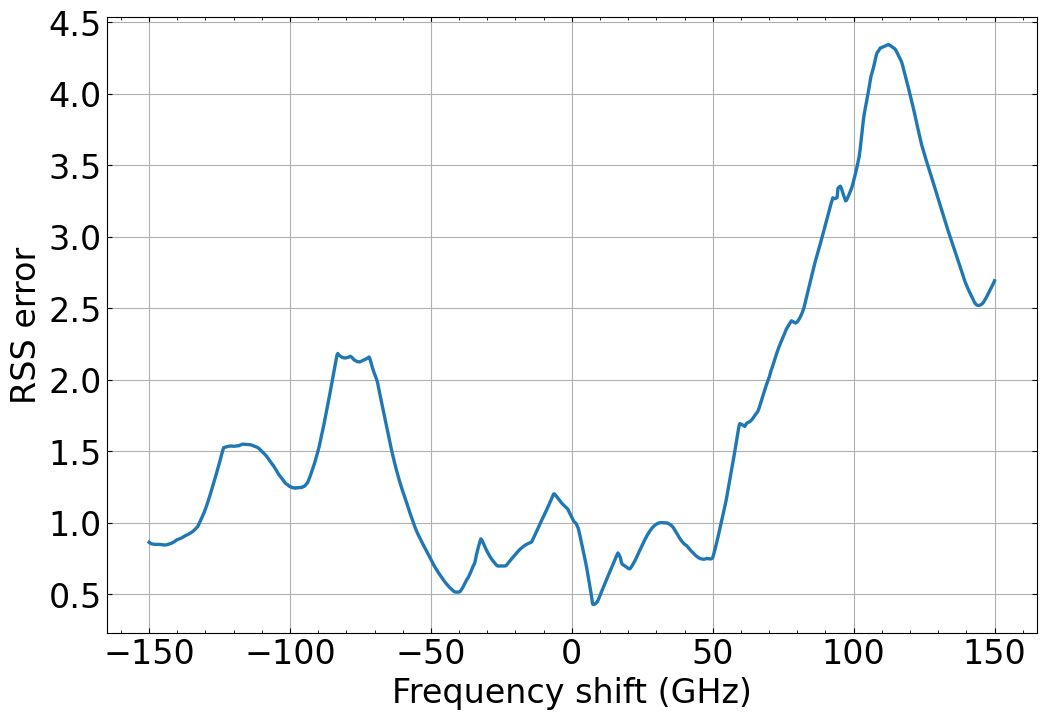

In [7]:
N = 1000; shift_range= 150e9
shifts = np.linspace(-shift_range, shift_range, N)
scores = np.empty(N)
RIPs = np.empty(N)
signal_size = np.empty(N)

for n, shift in enumerate(shifts):
    target = cs.generate_interferogram(total_points, central_freq= peak_freqs[0] +shift, pixel_pitch=pixel_pitch, FWHM_freq= FWHM, theta= theta)
    target += cs.generate_interferogram(total_points, central_freq= peak_freqs[1] +shift, pixel_pitch=pixel_pitch, FWHM_freq= FWHM, theta= theta)
    uncertainties = np.ones_like(target)

    scores[n] = cs.evaluate_score(test_config, target, uncertainties, regularization_coeffient)

fig, axs = plt.subplots(figsize= (12, 8))

axs.plot(shifts*1e-9, scores)
axs.set(xlabel= "Frequency shift (GHz)", ylabel= "RSS error")

plt.grid()
plt.show()
